In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import kagglehub

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


In [11]:
from google.colab import files
import os
import time

# This will prompt you to upload a file
print('Please upload your kaggle.json file')
uploaded = files.upload()

# --- NEW: Wait and Verify ---
# We will wait a moment and check if the file actually exists before moving it.
time.sleep(2) # Wait 2 seconds just in case

# This is the corrected line:
if 'kaggle.json' in os.listdir('/content/'):
    print("kaggle.json found! Configuring now...")

    # Set up the kaggle directory and permissions
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    print("\nKaggle API key configured successfully!")

    # --- Now, let's download the data ---
    !kaggle datasets download -d vipoooool/new-plant-diseases-dataset

    # --- And unzip it ---
    !unzip new-plant-diseases-dataset.zip

else:
    print("\n--- ERROR ---")
    print("Upload failed. The 'kaggle.json' file was not found.")
    print("Please try running this cell again and ensure the upload completes (you should see '100% done').")

Please upload your kaggle.json file


Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [2]:
import os
import tensorflow as tf

# --- IMPORTANT: This is the correct path for Google Colab ---
# After unzipping, the files are in the /content/ directory of the Colab machine.
DATA_DIR = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'

# Check if the directory exists to be sure
if not os.path.exists(DATA_DIR):
    print(f"Error: The directory was not found at {DATA_DIR}")
    print("Please make sure the '!unzip' command ran successfully in the previous cell.")
else:
    print(f"Successfully found data directory at: {DATA_DIR}")

# --- Define image and training parameters (these remain the same) ---
# We are reducing the image size and batch size to fit within Colab's free RAM.
IMAGE_SIZE = (128, 128)  # Reduced from (256, 256)
BATCH_SIZE = 16         # Reduced from 32
EPOCHS = 15

# --- Load the dataset from the Colab directory ---
# This part remains the same, but will now use the new parameters
DATA_DIR = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    shuffle=True,
    image_size=IMAGE_SIZE, # Uses the new smaller size
    batch_size=BATCH_SIZE,  # Uses the new smaller batch
    validation_split=0.2,
    subset='both',
    seed=123
)

train_ds, val_ds = dataset
class_names = train_ds.class_names
print("\nClass Names found:", len(class_names))

Successfully found data directory at: /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Using 14059 files for validation.

Class Names found: 38


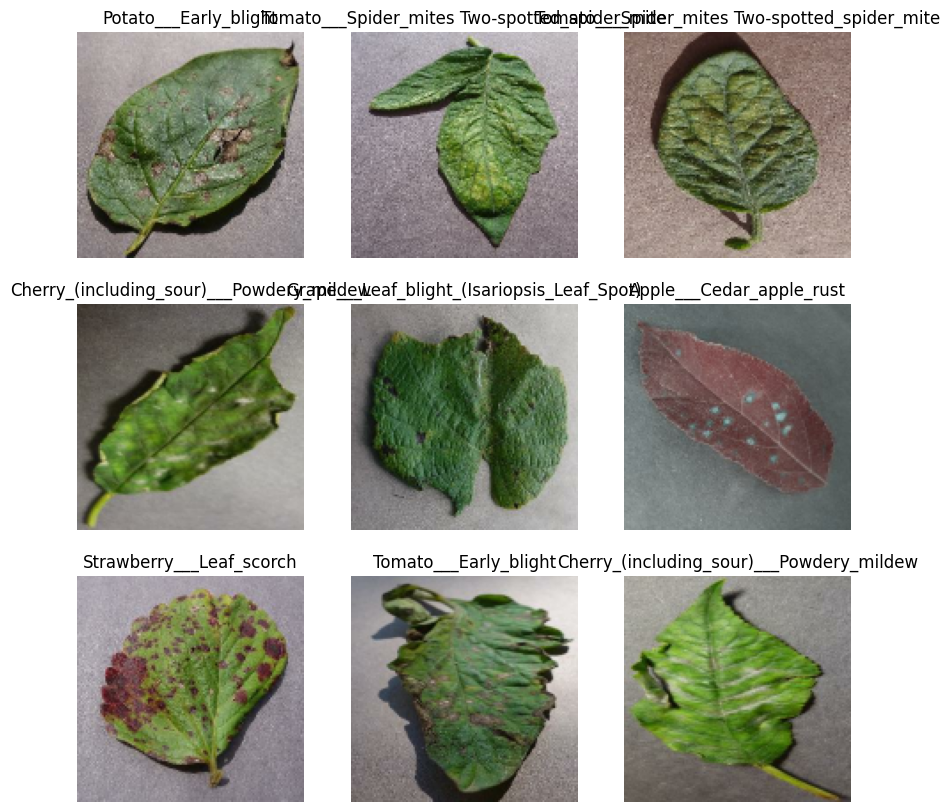

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

# --- CORRECTED CODE ---
# We have REMOVED .cache() to prevent the RAM from crashing.
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("Dataset configured successfully without caching.")

Dataset configured successfully without caching.


In [ ]:
from tensorflow.keras import layers, models

# Define the number of classes
num_classes = len(class_names)

# Create the model architecture
model = models.Sequential([
    # --- Data Augmentation Layers ---
    # IMPORTANT: The input_shape MUST match the new IMAGE_SIZE
    layers.RandomFlip("horizontal", input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    # --- Input Layer ---
    layers.Rescaling(1./255),

    # --- Convolutional Layers ---
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # --- Classifier Head ---
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# 
# Print a summary of the model's architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 861,670 (3.29 MB)

 Trainable params: 861,670 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 88s 18ms/step - accuracy: 0.3727 - loss: 2.2211 - val_accuracy: 0.7442 - val_loss: 0.8140
Epoch 2/15
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 116s 15ms/step - accuracy: 0.7975 - loss: 0.6522 - val_accuracy: 0.8190 - val_loss: 0.5880
Epoch 3/15
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - accuracy: 0.8597 - loss: 0.4381 - val_accuracy: 0.8548 - val_loss: 0.4562
Epoch 4/15
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 80s 15ms/step - accuracy: 0.8857 - loss: 0.3549 - val_accuracy: 0.8588 - val_loss: 0.4466
Epoch 5/15
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 59s 15ms/step - accuracy: 0.9013 - loss: 0.3071 - val_accuracy: 0.8951 - val_loss: 0.3360
Epoch 6/15
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 62s 15ms/step - accuracy: 0.9120 - loss: 0.2712 - val_accuracy: 0.8505 - val_loss: 0.5142
Epoch 7/15
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 80s 15ms/step - accuracy: 0.9207 - loss: 0.2459 - val_accuracy: 0.8843 - val_loss: 0.4113
Epoch 8/15
3515/3515 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - accuracy: 0.9264 

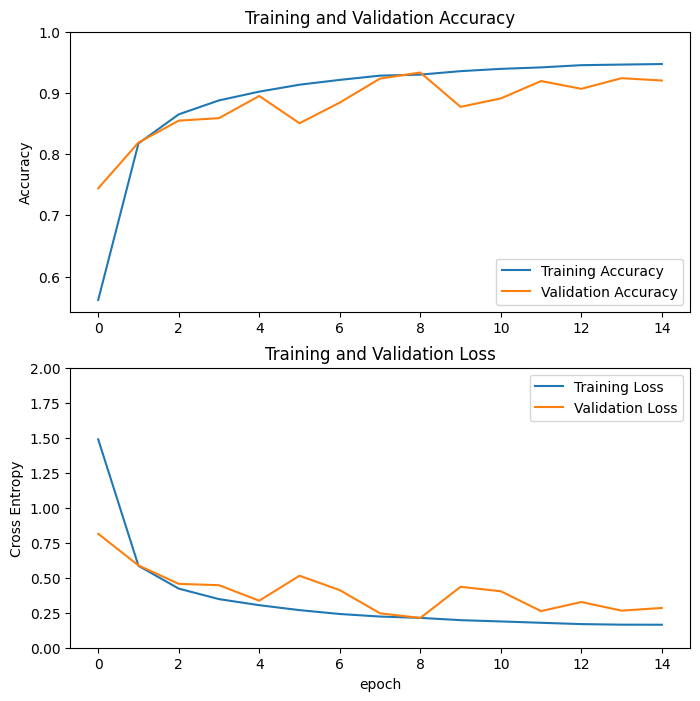

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import os

# --- MODIFIED FOR GOOGLE COLAB ---

# 1. Define the directory and filename for the model.
#    We will save it in the main /content/ directory for easy access.
model_dir = "/content/models/"
model_filename = "plant_disease_model_v1.h5"
model_path = os.path.join(model_dir, model_filename)

# 2. Create the directory if it doesn't exist.
os.makedirs(model_dir, exist_ok=True)

# 3. Save the model.
model.save(model_path)

print("---" * 10)
print(f"✅ Model saved successfully at: {model_path}")
print("---" * 10)



------------------------------
✅ Model saved successfully at: /content/models/plant_disease_model_v1.h5
------------------------------

You can now find the 'models' folder in the file browser on the left and download your 'plant_disease_model_v1.h5' file.
